# Image Segmentation Task 1
#### Welcome to the first task of Image Segmentation. Image segmentation is the process of partitioning the image into a set of pixels representing an object. In this task, you will be introduced to the problem of image segmentation and programming pipeline involved in image segmentation.

For the purpose of this task we will be using PASCAL VOC datset. The dataset contains a total of 2913 images with segmentation annotations. Code in the cell below will download the code and extract the dataset.

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf VOCtrainval_11-May-2012.tar

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install scipy==1.1.0
!sudo pip install --upgrade scipy==1.1.0

     |████████████████████████████████| 31.2MB 103kB/s 
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [ ]:
cd '/content/drive/MyDrive/NN'


/content/drive/MyDrive/NN


### 1.1 Loading the dataset

In [ ]:
import os
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt
import glob

from PIL import Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from torch.autograd import Variable

class pascalVOCDataset(data.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of five data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        trainval: The combination of `train` and `val` - 2913 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
        train_aug_val: The original VOC 2012 validation data minus the images
                   present in `train_aug` (This is done with the same logic as
                   the validation set used in FCN PAMI paper, but with VOC 2012
                   rather than VOC 2011) - 904 images
    """

    def __init__(
        self,
        root,
        sbd_path=None,
        split="train_aug",
        is_transform=False,
        img_size=512,
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        if not self.test_mode:
            for split in ["train", "val", "trainval"]:
                path = pjoin(self.root, "ImageSets/Segmentation", split + ".txt")
                file_list = tuple(open(path, "r"))
                file_list = [id_.rstrip() for id_ in file_list]
                self.files[split] = file_list
            self.setup_annotations()

        self.tf = transforms.Compose(
            [
                # add more trasnformations as you see fit
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", im_name + ".png")
        im = Image.open(im_path)
        lbl = Image.open(lbl_path)
        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform:
            im, lbl = self.transform(im, lbl)
        return im, torch.clamp(lbl, max=20)

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = img.resize((self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
            lbl = lbl.resize((self.img_size[0], self.img_size[1]))
        img = self.tf(img)
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl

    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        # print(np.unique(label_mask))
        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """Sets up Berkley annotations by adding image indices to the
        `train_aug` split and pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). This
        function also defines the `train_aug` and `train_aug_val` data splits
        according to the description in the class docstring
        """
        sbd_path = self.sbd_path
        target_path = pjoin(self.root, "SegmentationClass/pre_encoded")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        train_aug = self.files["train"]

        # keep unique elements (stable)
        train_aug = [train_aug[i] for i in sorted(np.unique(train_aug, return_index=True)[1])]
        self.files["train_aug"] = train_aug
        set_diff = set(self.files["val"]) - set(train_aug)  # remove overlap
        self.files["train_aug_val"] = list(set_diff)

        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        expected = np.unique(self.files["train_aug"] + self.files["val"]).size

        if len(pre_encoded) != expected:
            print("Pre-encoding segmentation masks...")

            for ii in tqdm(self.files["trainval"]):
                fname = ii + ".png"
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = self.encode_segmap(m.imread(lbl_path))
                lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                m.imsave(pjoin(target_path, fname), lbl)

        assert expected == 2913, "unexpected dataset sizes"

### 1.2 Define the model architecture(2.0 point)
In this section you have the freedom to decide your own model. Keep in mind though, to perform image segmentation, you need to implement an architecture that does pixel level classification i.e. for each pixel in the image you need to predict the probability of it belonging to one of the 21 categories.

In [6]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models.vgg import VGG


vgg16_layers = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
vgg16_ranges = ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31))

class VGGNet(VGG):
    def __init__(self,  layers, ranges, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(layers))
        self.ranges = ranges

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


class Segnet(nn.Module):
  
  def __init__(self, pretrained_net, n_class):
    super(Segnet, self).__init__()
    #define the layers for your model
    self.n_class = n_class
    self.pretrained_net = pretrained_net
    self.relu    = nn.ReLU(inplace=True)
    self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn1     = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn2     = nn.BatchNorm2d(256)
    self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn3     = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn4     = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
    self.bn5     = nn.BatchNorm2d(32)
    self.classifier = nn.Conv2d(32, n_class, kernel_size=1)    

  def forward(self, x):
        #define the forward pass
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)
        x2 = output['x2']  # size=(N, 128, x.H/4,  x.W/4)
        x1 = output['x1']  # size=(N, 64, x.H/2,  x.W/2)

        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = score + x4                                # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = score + x3                                # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = score + x2                                # element-wise add, size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = score + x1                                # element-wise add, size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)    





In [7]:
# Creating an instance of the model defined above. 
# You can modify it incase you need to pass paratemers to the constructor.
#from segmentation.models import all_models
vgg16_layers = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
vgg16_ranges = ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31))

vgg_model = VGGNet(model='vgg16', requires_grad=True, remove_fc=True, layers = vgg16_layers, ranges=vgg16_ranges)
model = Segnet(pretrained_net=vgg_model, n_class=21)
model.cuda()



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Segnet(
  (pretrained_net): VGGNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
 

### 1.3 Hyperparameters(0.5 points)
Define all the hyperparameters(not restricted to the three given below) that you find useful here.

In [ ]:
root = '/content/drive/MyDrive/NN/'
local_path = root+'VOCdevkit/VOC2012/' # modify it according to your device
bs = 12
epochs = 20
lr         = 1e-4
momentum   = 0
w_decay    = 1e-5


### 1.4 Dataset and Dataloader(0.5 points)
Create the dataset using pascalVOCDataset class defined above. Use local_path defined in the cell above as root. 

In [ ]:
# dataset variable
dst = pascalVOCDataset(root = local_path, is_transform=True)
val_dst = pascalVOCDataset(root = local_path, split='val', is_transform=True)

# dst = Subset(dst, list(range(120)))
# dataloader variable
trainloader = DataLoader(dst, batch_size=bs, shuffle=True )
valloader = DataLoader(val_dst, batch_size=bs, shuffle=True )


### 1.5 Loss fuction and Optimizer(1.0 point)
Define below with the loss function you think would be most suitable for segmentation task. You are free to choose any optimizer to train the network.

In [ ]:
# loss function
loss_f = nn.CrossEntropyLoss()

# optimizer variable
opt = optim.Adam(model.parameters(), lr=lr, weight_decay=w_decay)

### 1.6 Training the model(3.0 points)
Your task here is to complete the code below to perform a training loop and save the model weights after each epoch of training.

In [ ]:
for e in range(epochs):
  for i, (img,lab) in enumerate(trainloader):
    # your code goes here
    opt.zero_grad()
    inputs = img.cuda()
    labels = lab.cuda()

    outputs = model(inputs)
    loss = loss_f(outputs.float(), labels)
    loss.backward()
    opt.step() 
    if i % 10 == 0:
        print("epoch{}, iter{}, loss: {}".format(e, i, loss.data))
  with torch.no_grad():
        for i, (img, lab) in enumerate(valloader):
                inputs = img.cuda()
                labels = lab.cuda()
                outputs = model(inputs)
                val_loss = loss_f(outputs.float(), labels)
        print("epoch{}, Validation loss: {}".format(e, val_loss.data))

  torch.save(model.cpu().state_dict(), local_path+'model_epoch_'+str(e)+'.pth')
  model.cuda()

epoch10, iter0, loss: 0.7306725382804871
epoch10, iter10, loss: 0.6729044318199158
epoch10, iter20, loss: 0.6821053624153137
epoch10, iter30, loss: 0.6467251181602478
epoch10, iter40, loss: 0.5934838652610779
epoch10, iter50, loss: 0.619584321975708
epoch10, iter60, loss: 0.7416703701019287
epoch10, iter70, loss: 0.8829068541526794
epoch10, iter80, loss: 0.725324809551239
epoch10, iter90, loss: 0.8458043932914734
epoch10, iter100, loss: 0.5246261358261108
epoch10, iter110, loss: 0.5717996954917908
epoch10, iter120, loss: 0.6780455112457275
epoch10, Validation loss: 0.6978316903114319
epoch11, iter0, loss: 0.6333944201469421
epoch11, iter10, loss: 0.634127140045166
epoch11, iter20, loss: 0.6506521701812744
epoch11, iter30, loss: 0.6063836812973022
epoch11, iter40, loss: 0.7314055562019348
epoch11, iter50, loss: 0.6436792612075806
epoch11, iter60, loss: 0.5217234492301941
epoch11, iter70, loss: 0.567532479763031
epoch11, iter80, loss: 0.49376988410949707
epoch11, iter90, loss: 0.74595826

### 1.7 Evaluate your model(1.5 points)
In this section you have to implement the evaluation metrics for your model. Calculate the values of F1-score, dice coefficient and AUC-ROC score on the data you used for training. You can use external packages like scikit-learn to compute above metrics.

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, jaccard_score
from sklearn import metrics
from scipy.spatial.distance import dice
from sklearn.metrics import confusion_matrix

def evaluate(ground_truth, predictions):
    # print(ground_truth.shape, predictions.shape)
    f1, auc, dice, jaccard, accuracy = [], [], [], [], []    
    for i,j in zip(predictions, ground_truth):
        correct = torch.sum(i.argmax(0)==j)
        total = torch.numel(j)
        tr_ac = correct/float(total)
        accuracy.append(tr_ac.cpu().detach().numpy())
        conf_mat = confusion_matrix(j.reshape(-1).cpu().detach().numpy(), i.argmax(0).reshape(-1).cpu().detach().numpy(), labels=list(range(21)))
        weights = []
        for l in range(conf_mat.shape[0]):        
            c = (conf_mat[l,:].sum())/conf_mat.sum()
            weights.append(c)
        weights = np.nan_to_num(weights)

        dices_sc = []
        for k in range(conf_mat.shape[0]):
            tp = conf_mat[k][k]
            fp = (conf_mat[:,k].sum() - conf_mat[k][k])
            fn = (conf_mat[k,:].sum() - tp)
            denom = ((2*tp)+fp+fn)
            if(denom!=0):
                dice_score = (2*tp) / denom
                dices_sc.append(dice_score)
            else:
                dices_sc.append(0)
        
        dices_sc = np.nan_to_num(dices_sc)
        weighted_dice = np.sum(weights * dices_sc)
        dice.append(weighted_dice)
        f1_sco = (f1_score(i.argmax(0).reshape(-1).cpu().detach().numpy(), j.reshape(-1).cpu().detach().numpy(), average='weighted'))
        f1.append(f1_sco)
        jaccard_sco = (jaccard_score(i.argmax(0).reshape(-1).cpu().detach().numpy(), j.reshape(-1).cpu().detach().numpy(), average='weighted'))
        jaccard.append(jaccard_sco)

        # i = i.reshape(21, 512*512)
        # i = i.transpose(0,1).softmax(1)
        # j = j.reshape(-1)


    return f1, auc, dice, jaccard, accuracy
    


    

### 1.8 Plot the evaluation metrics against epochs(1.0)
In section 1.6 we saved the weights of the model after each epoch. In this section, you have to calculate the evaluation metrics after each epoch of training by loading the weights for each epoch. Once you have calculated the evaluation metrics for each epoch, plot them against the epochs.

In [ ]:
final_f1, final_roc_auc, final_dice, final_jacc, final_acc = [] , [], [], [], []
print(len(dst))

torch.cuda.empty_cache()
for e in range(epochs):
    model = Segnet(pretrained_net=vgg_model, n_class=21)
    model.load_state_dict(torch.load(local_path+'model_epoch_'+str(e)+'.pth'))
    model.cuda()
    f1_scores, roc_auc_scores, dice_scores, jaccard_scores, accuracy_scores = [], [], [], [], []
    for i, (img,lab) in enumerate(trainloader):
        inputs = img.cuda()
        labels = lab.cuda()
        outputs = model(inputs)
        outputs = outputs.cuda()
        # print(outputs.shape, labels.shape)
        f1, roc_auc, dice, jacc, acc = evaluate(labels, outputs)
        f1_scores.extend(f1)
        roc_auc_scores.extend(roc_auc)
        dice_scores.extend(dice)
        jaccard_scores.extend(jacc)
        accuracy_scores.extend(acc)
        #print(np.mean(f1), np.mean(roc_auc), np.mean(dice), np.mean(jacc), np.mean(acc))
    print("Epoch: {}, Mean F1 Score: {}".format(e, np.mean(f1_scores)))
    print("Epoch: {}, Mean ROC AUC Score: {}".format(e, np.mean(roc_auc_scores)))
    print("Epoch: {}, Mean Dice Score: {}".format(e, np.mean(dice_scores)))
    print("Epoch: {}, Mean Jaccard Score: {}".format(e, np.mean(jaccard_scores)))
    print("Epoch: {}, Mean Accuracy Score: {}".format(e, np.mean(accuracy_scores)))

    final_f1.append(np.mean(f1_scores))
    final_roc_auc.append(np.mean(roc_auc_scores))
    final_dice.append(np.mean(dice_scores))
    final_jacc.append(np.mean(jaccard_scores))
    final_acc.append(np.mean(accuracy_scores))
print(final_f1)
print(final_roc_auc)
print(final_dice)
print(final_jacc)
print(final_acc)

1464
Epoch: 10, Mean F1 Score: 0.8664376686517543
Epoch: 10, Mean ROC AUC Score: 0.0
Epoch: 10, Mean Dice Score: 0.8661256367705022
Epoch: 10, Mean Jaccard Score: 0.8386238603233407
Epoch: 10, Mean Accuracy Score: 0.8662816286087036
Epoch: 11, Mean F1 Score: 0.8792081693852198
Epoch: 11, Mean ROC AUC Score: 0.0
Epoch: 11, Mean Dice Score: 0.8857490449285583
Epoch: 11, Mean Jaccard Score: 0.8523226480762043
Epoch: 11, Mean Accuracy Score: 0.882478654384613
Epoch: 12, Mean F1 Score: 0.891886381860343
Epoch: 12, Mean ROC AUC Score: 0.0
Epoch: 12, Mean Dice Score: 0.8993640085728799
Epoch: 12, Mean Jaccard Score: 0.8656696253749954
Epoch: 12, Mean Accuracy Score: 0.8956252336502075
Epoch: 13, Mean F1 Score: 0.8850969474014623
Epoch: 13, Mean ROC AUC Score: 0.0
Epoch: 13, Mean Dice Score: 0.889162875214698
Epoch: 13, Mean Jaccard Score: 0.8536615764421143
Epoch: 13, Mean Accuracy Score: 0.8871298432350159
Epoch: 14, Mean F1 Score: 0.8997996454570785
Epoch: 14, Mean ROC AUC Score: 0.0
Epoch:

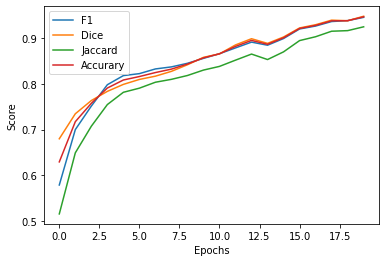

In [15]:

## Putting the results in a list and plotting them
final_f1 = [0.5782970449311633, 0.6998703190363987, 0.7515588166807682, 0.7983927456098457, 0.8183998087355184, 0.8227372961386749, 0.8330408384015965, 0.8375287501483062, 0.8454280072080482, 0.8562617233030508, 0.8664376686517543, 0.8792081693852198, 0.891886381860343, 0.8850969474014623, 0.8997996454570785, 0.920770658832093, 0.9271650422328831, 0.9370892521627214, 0.9390375572466695, 0.9462553193463359]
final_dice = [0.6797608881049322, 0.7346320480770586, 0.7636769591260966, 0.7838025467952464, 0.7991177563819892, 0.8100018022069723, 0.817165466888584, 0.8277345144087453, 0.8422052726861708, 0.858490958616735, 0.8661256367705022, 0.8857490449285583, 0.8993640085728799, 0.889162875214698, 0.9031831903646882, 0.9230081546394666, 0.9300787353913619, 0.9401263260936877, 0.9388409445203483, 0.9486949324153454]
final_jaccard = [0.5148392820752954, 0.6488883158486135, 0.7073203260573051, 0.7548595553457027, 0.781782248106138, 0.7908393371649619, 0.8038557278360559, 0.8102210033836974, 0.8186329017980852, 0.8305328545255829, 0.8386238603233407, 0.8523226480762043, 0.8656696253749954, 0.8536615764421143, 0.8705522125582213, 0.8952725011285658, 0.903717928823227, 0.91581754771982, 0.9171044383399619, 0.9255103781600412]
final_acc = [0.6290289, 0.71725124, 0.7576179, 0.7910977, 0.80875885, 0.81636953, 0.82510316, 0.8326316, 0.8438167, 0.85737634, 0.8662816, 0.88247865, 0.89562523, 0.88712984, 0.9014914, 0.9218894, 0.9286219, 0.9386078, 0.93893933, 0.94747514]
eps = list(range(20))
plt.plot(eps, final_f1, label='F1')
plt.plot(eps, final_dice, label='Dice')
plt.plot(final_jaccard, label='Jaccard')
plt.plot(final_acc, label='Accurary')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.show()

### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.

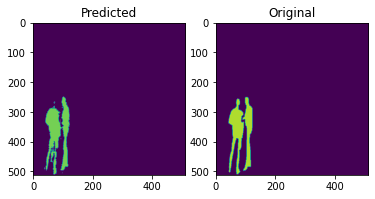

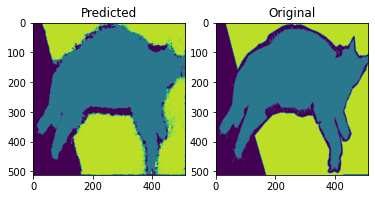

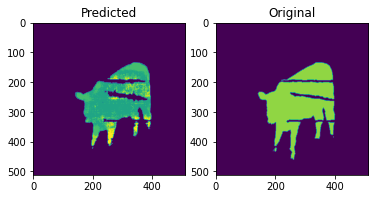

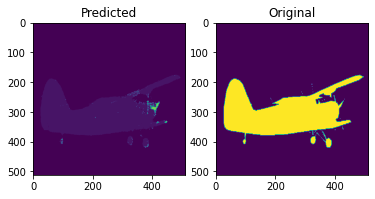

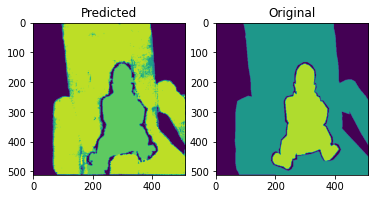

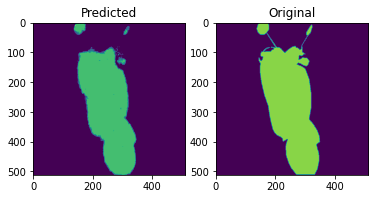

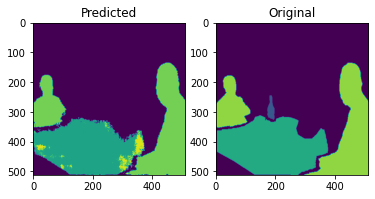

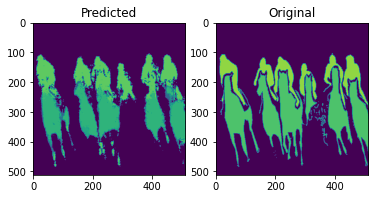

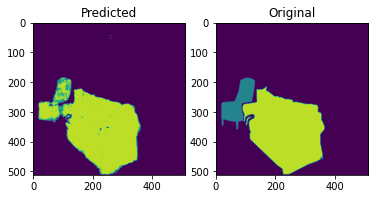

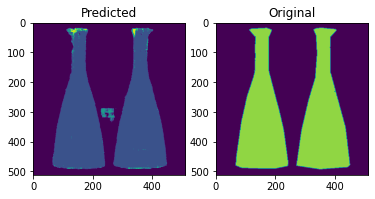

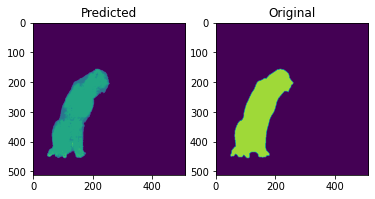

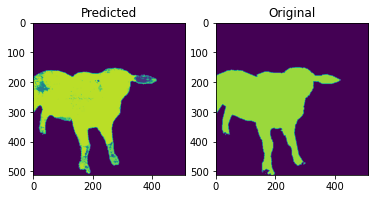

In [22]:
from matplotlib import pyplot as plt
for i, (img,lab) in enumerate(trainloader):
    inputs = img.cuda()
    outputs = model(inputs)
    outputs = outputs.argmax(1)
    outputs = outputs.cpu().detach().numpy()
    for pred,orig in zip(outputs,lab):
        f, axarr = plt.subplots(1,2)
        # axarr[0].imshow(dst.decode_segmap(pred))
        axarr[0].imshow(pred)
        axarr[1].imshow(orig)
        axarr[0].title.set_text('Predicted')
        axarr[1].title.set_text('Original')
        plt.show()
    break